In [ ]:
# autoreloadを有効化
%load_ext autoreload
%autoreloa

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# フーリエ変換

In [ ]:
import numpy as np

def fourier_series_coeffs(func, T=1.0, M=32, N=None, x0=0.0):
    """
    フーリエ求数
        f(x) ≈ Σ_{k=-M..M} c_k exp(-2π i k x / T)
    の係数を計算する

    Args:
        func : callable, 複素値可。ベクトル化推奨。
        T    : 周期
        M    : 取り出す最大次数（-M..M）
        N    : サンプル数（既定は 2*M+1（奇数））
        x0   : サンプリング開始点（位相補正により c_k は開始点に依存しない形で返す）
    
    Returns:
        ks (整数配列): kのリスト
        cs (複素係数配列): 係数c_kのリスト
        meta dict
    """
    if N is None:
        N = 2*M + 1  # 推奨：奇数 → kがちょうど -M..M
    if M > N//2:
        raise ValueError("M は N/2 以下にしてください。")

    # 等間隔サンプリング（1周期）
    ns = np.arange(N)
    xs = x0 + (T * ns / N)
    fs = np.asarray(func(xs), dtype=complex)

    # DFT → 係数（Riemann和より c_k ≈ (1/N) Σ f_n e^{-2π i k n/N}）
    F = np.fft.fft(fs) / N          # k=0..N-1
    Fc = np.fft.fftshift(F)        # k を中心化

    # 対応する整数 k 配列
    if N % 2 == 1:
        k_all = np.arange(-(N//2), N//2 + 1)   # 例: N=2M+1 → -M..M
    else:
        k_all = np.arange(-N//2, N//2)         # 偶数の場合

    # サンプリング開始 x0 の位相補正（基底は x に対する e^{-2π i k x/T}）
    phase = np.exp(2j * np.pi * k_all * (x0 / T))
    c_all = Fc * phase

    # -M..M を抽出
    pick = (k_all >= -M) & (k_all <= M)
    ks = k_all[pick]
    cs = c_all[pick]
    return ks, cs, {"T": T, "M": M, "N": N, "x0": x0}

def fourier_series_eval(xs, ks, cs, T):
    xs = np.asarray(xs)
    return np.sum(cs[:, None] * np.exp(-2j * np.pi * ks[:, None] * (xs / T)), axis=0)

def periodic_extension(f_base, L):
    return lambda x: f_base(((np.asarray(x)+L) % (2*L)) - L)



ks: [-2 -1  0  1  2]
cs: [0.05323181-1.30380332e-17j 0.24282628-2.97376423e-17j
 0.3980458 +0.00000000e+00j 0.24282628+2.97376423e-17j
 0.05323181+1.30380332e-17j]


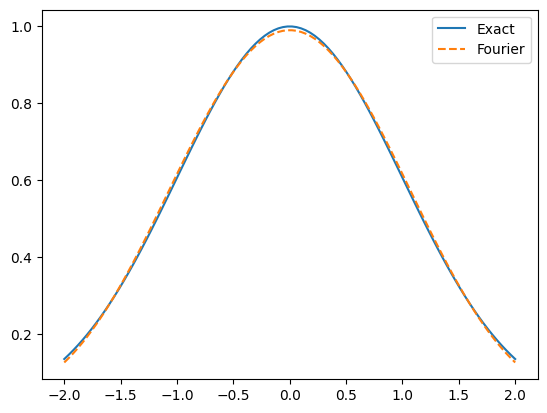

In [ ]:
# ガウス関数
sigma = 1.0
func = lambda x: 1/np.sqrt(sigma) * np.exp(-x*x / (2*sigma*sigma))

# フーリエ求数計算
# サンプリング範囲 = (-np.pi, +np.pi)を10点
T = 2 * np.pi
x0 = -T/2
N = 10
# フーリエ求数は [+M,...,-M]の範囲
M = 2

ks, cs, _ = fourier_series_coeffs(func, x0=-T/2, T=T, M=M, N=N)

print("ks:", ks)
print("cs:", cs)

# 確かめ
xs = np.linspace(-2, 2, 100)
ys_exact = func(xs)
ys_fourier = fourier_series_eval(xs, ks, cs, T)
plt.plot(xs, ys_exact.real, label="Exact")
plt.plot(xs, ys_fourier.real, "--", label="Fourier")
plt.legend()

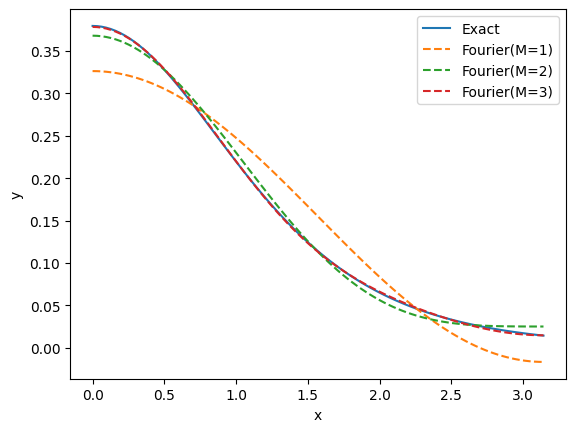

In [49]:
from scipy.stats import t

# Student-t
mu = 0.0     # 平均
sigma = 1.0  # スケール（標準偏差に相当）
nu = 5       # 自由度
def func(x):
    return t.pdf(x, df=nu, loc=mu, scale=sigma)

# フーリエ求数計算
# サンプリング範囲 = (0, 2*np.pi)を10点
T = 2 * np.pi
x0 = 0
N = 10
# フーリエ求数は [+M,...,-M]の範囲
# M = 5


# exact
xs = np.linspace(0, T/2, 100)
ys_exact = func(xs)
plt.plot(xs, ys_exact.real, label="Exact")

f = periodic_extension(func, T/2)
for M in [1, 2, 3]:
    ks, cs, _ = fourier_series_coeffs(f, x0=0, T=T, M=M, N=N)
    ys_fourier = fourier_series_eval(xs, ks, cs, T)
    plt.plot(xs, ys_fourier.real, "--", label="Fourier(M={})".format(M))
plt.xlabel("x")
plt.ylabel("y")
plt.legend()